In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from torchvision import transforms
import torchvision
import numpy as np
from resnet import ResNet, Bottleneck

class Trainer:
    def __init__(self, name, model, criterion, optimizer, device):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The PyTorch model to train.
            criterion (nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            device (torch.device): The device to train on (e.g., 'cuda' or 'cpu').
        """
        self.name = name
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, dataloader):
        """
        Trains the model for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the training set.

        Returns:
            float: The average training loss for the epoch.
        """
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)

        for inputs, labels in dataloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate_epoch(self, dataloader):
        """
        Evaluates the model on the validation set for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the validation set.

        Returns:
            float: The average validation loss for the epoch.
            float: The average validation accuracy for the epoch.
        """
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / total_samples
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        return avg_loss, accuracy

    def train(self, train_dataloader, val_dataloader, num_epochs):
        """
        Trains the model for a specified number of epochs and validates it, recording latency and throughput.

        Args:
            train_dataloader (DataLoader): The DataLoader for the training set.
            val_dataloader (DataLoader): The DataLoader for the validation set.
            num_epochs (int): The number of training epochs.
        """
        print(f"Training on {self.device}")
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_dataloader)
            val_loss, val_acc = self.validate_epoch(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    def plot_losses_accuracies(self):
        """
        Plots the training loss, validation loss, and validation accuracy against the number of epochs.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure()
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(self.name + ' Training and Validation Loss')
        plt.legend()
        plt.show()

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trans)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

@torch.no_grad()
def measure_inference_time_with_warmup(model, data_loader, warmup_steps=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    # Warm-up
    for i, (inputs, _) in enumerate(data_loader):
        inputs = inputs.to(device)
        _ = model(inputs)
        if i >= warmup_steps - 1:
            break

    total_inference_time = 0
    num_samples = 0
    start_time = time.time() # Start timer after warm-up

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        num_samples += inputs.size(0)

    end_time = time.time()
    total_inference_time = end_time - start_time
    throughput = num_samples / total_inference_time
    avg_latency_per_sample = total_inference_time / num_samples
    print(f"Average Latency per Sample (with warm-up): {avg_latency_per_sample * 1000:.2f} ms")
    print(f"Throughput (with warm-up): {throughput:.2f} samples/second")
    return avg_latency_per_sample, throughput

def fit_one(name,model,epochs,train_dataloader,val_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(name = name,model = model,criterion = nn.CrossEntropyLoss(),optimizer= optim.SGD(model.parameters(),weight_decay=0.0001,momentum=0.9),device=device)
    trainer.train(train_dataloader, val_dataloader, epochs)
    trainer.plot_losses_accuracies()
    max_acc = np.max(trainer.val_accuracies)
    avg_latency, throughput = measure_inference_time_with_warmup(model, val_dataloader)
    return avg_latency,max_acc

100%|██████████| 170M/170M [00:04<00:00, 37.7MB/s]


Training on cuda
Epoch [1/20], Train Loss: 1.9159, Val Loss: 1.7794, Val Acc: 0.3594
Epoch [2/20], Train Loss: 1.5531, Val Loss: 1.6463, Val Acc: 0.4180
Epoch [3/20], Train Loss: 1.3914, Val Loss: 1.5466, Val Acc: 0.4538
Epoch [4/20], Train Loss: 1.2745, Val Loss: 1.3969, Val Acc: 0.4903
Epoch [5/20], Train Loss: 1.1816, Val Loss: 1.2709, Val Acc: 0.5397
Epoch [6/20], Train Loss: 1.0848, Val Loss: 1.2830, Val Acc: 0.5402
Epoch [7/20], Train Loss: 0.9967, Val Loss: 1.2567, Val Acc: 0.5547
Epoch [8/20], Train Loss: 0.9134, Val Loss: 1.2845, Val Acc: 0.5453
Epoch [9/20], Train Loss: 0.8274, Val Loss: 1.3178, Val Acc: 0.5461
Epoch [10/20], Train Loss: 0.7480, Val Loss: 1.2330, Val Acc: 0.5741
Epoch [11/20], Train Loss: 0.6632, Val Loss: 1.2866, Val Acc: 0.5664
Epoch [12/20], Train Loss: 0.5789, Val Loss: 1.3008, Val Acc: 0.5725
Epoch [13/20], Train Loss: 0.4965, Val Loss: 1.3479, Val Acc: 0.5703
Epoch [14/20], Train Loss: 0.4199, Val Loss: 1.4638, Val Acc: 0.5592
Epoch [15/20], Train Loss:

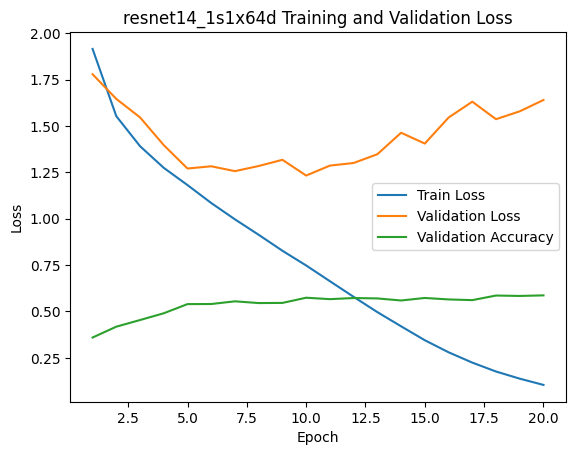

Average Latency per Sample (with warm-up): 0.13 ms
Throughput (with warm-up): 7624.31 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.6972, Val Loss: 1.5292, Val Acc: 0.4422
Epoch [2/20], Train Loss: 1.3696, Val Loss: 1.3579, Val Acc: 0.5073
Epoch [3/20], Train Loss: 1.2216, Val Loss: 1.3788, Val Acc: 0.5047
Epoch [4/20], Train Loss: 1.1165, Val Loss: 1.4022, Val Acc: 0.5167
Epoch [5/20], Train Loss: 1.0255, Val Loss: 1.2985, Val Acc: 0.5342
Epoch [6/20], Train Loss: 0.9452, Val Loss: 1.1640, Val Acc: 0.5897
Epoch [7/20], Train Loss: 0.8730, Val Loss: 1.1219, Val Acc: 0.6060
Epoch [8/20], Train Loss: 0.8024, Val Loss: 1.1013, Val Acc: 0.6123
Epoch [9/20], Train Loss: 0.7325, Val Loss: 1.0959, Val Acc: 0.6215
Epoch [10/20], Train Loss: 0.6693, Val Loss: 1.1682, Val Acc: 0.6107
Epoch [11/20], Train Loss: 0.6068, Val Loss: 1.1173, Val Acc: 0.6188
Epoch [12/20], Train Loss: 0.5379, Val Loss: 1.3663, Val Acc: 0.5725
Epoch [13/20], Train Loss: 0.4820, Val Loss: 1.2028, Val Acc: 0

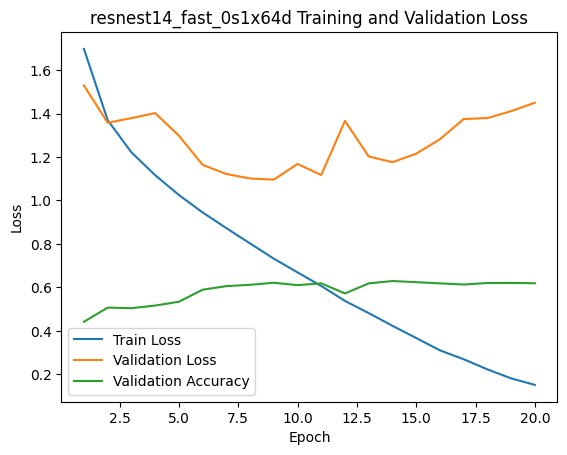

Average Latency per Sample (with warm-up): 0.17 ms
Throughput (with warm-up): 5826.05 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.7300, Val Loss: 1.4833, Val Acc: 0.4618
Epoch [2/20], Train Loss: 1.4021, Val Loss: 1.3641, Val Acc: 0.5038
Epoch [3/20], Train Loss: 1.2658, Val Loss: 1.2981, Val Acc: 0.5331
Epoch [4/20], Train Loss: 1.1625, Val Loss: 1.2464, Val Acc: 0.5540
Epoch [5/20], Train Loss: 1.0735, Val Loss: 1.2370, Val Acc: 0.5566
Epoch [6/20], Train Loss: 0.9963, Val Loss: 1.2933, Val Acc: 0.5518
Epoch [7/20], Train Loss: 0.9273, Val Loss: 1.1861, Val Acc: 0.5834
Epoch [8/20], Train Loss: 0.8603, Val Loss: 1.2308, Val Acc: 0.5742
Epoch [9/20], Train Loss: 0.7913, Val Loss: 1.1455, Val Acc: 0.5973
Epoch [10/20], Train Loss: 0.7252, Val Loss: 1.1676, Val Acc: 0.6039
Epoch [11/20], Train Loss: 0.6613, Val Loss: 1.1636, Val Acc: 0.6056
Epoch [12/20], Train Loss: 0.5978, Val Loss: 1.1630, Val Acc: 0.6112
Epoch [13/20], Train Loss: 0.5350, Val Loss: 1.2148, Val Acc: 0

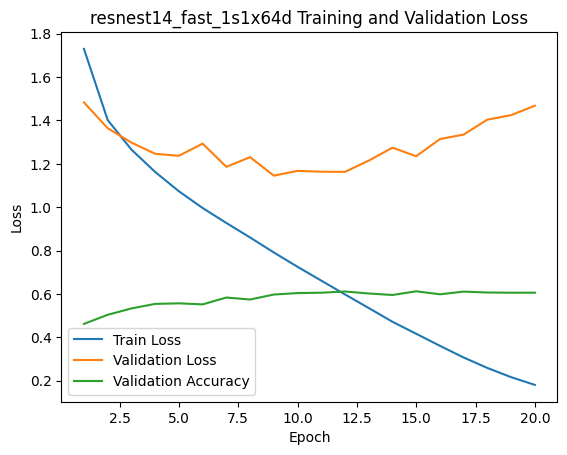

Average Latency per Sample (with warm-up): 0.13 ms
Throughput (with warm-up): 7797.43 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.7579, Val Loss: 1.5479, Val Acc: 0.4371
Epoch [2/20], Train Loss: 1.4376, Val Loss: 1.4803, Val Acc: 0.4585
Epoch [3/20], Train Loss: 1.3035, Val Loss: 1.3231, Val Acc: 0.5264
Epoch [4/20], Train Loss: 1.2030, Val Loss: 1.2657, Val Acc: 0.5445
Epoch [5/20], Train Loss: 1.1224, Val Loss: 1.2645, Val Acc: 0.5442
Epoch [6/20], Train Loss: 1.0513, Val Loss: 1.2855, Val Acc: 0.5424
Epoch [7/20], Train Loss: 0.9922, Val Loss: 1.1828, Val Acc: 0.5743
Epoch [8/20], Train Loss: 0.9301, Val Loss: 1.2822, Val Acc: 0.5579
Epoch [9/20], Train Loss: 0.8753, Val Loss: 1.1624, Val Acc: 0.5931
Epoch [10/20], Train Loss: 0.8200, Val Loss: 1.1730, Val Acc: 0.5927
Epoch [11/20], Train Loss: 0.7630, Val Loss: 1.1686, Val Acc: 0.6025
Epoch [12/20], Train Loss: 0.7084, Val Loss: 1.2132, Val Acc: 0.5890
Epoch [13/20], Train Loss: 0.6577, Val Loss: 1.2237, Val Acc: 0

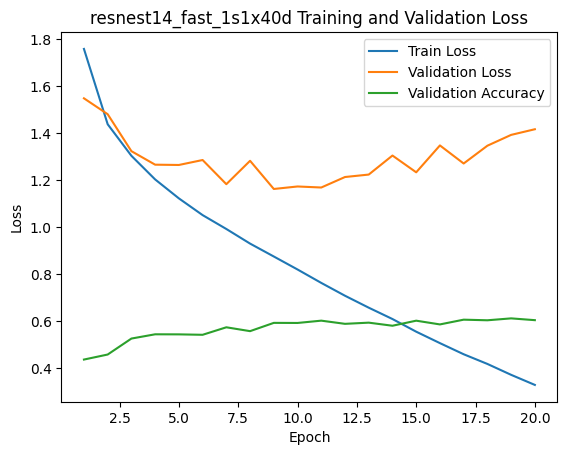

Average Latency per Sample (with warm-up): 0.14 ms
Throughput (with warm-up): 6967.22 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.7066, Val Loss: 1.4633, Val Acc: 0.4717
Epoch [2/20], Train Loss: 1.3396, Val Loss: 1.3398, Val Acc: 0.5153
Epoch [3/20], Train Loss: 1.1733, Val Loss: 1.3228, Val Acc: 0.5223
Epoch [4/20], Train Loss: 1.0543, Val Loss: 1.2456, Val Acc: 0.5611
Epoch [5/20], Train Loss: 0.9543, Val Loss: 1.1767, Val Acc: 0.5836
Epoch [6/20], Train Loss: 0.8618, Val Loss: 1.1453, Val Acc: 0.5979
Epoch [7/20], Train Loss: 0.7728, Val Loss: 1.1383, Val Acc: 0.5981
Epoch [8/20], Train Loss: 0.6891, Val Loss: 1.1816, Val Acc: 0.5968
Epoch [9/20], Train Loss: 0.6048, Val Loss: 1.2334, Val Acc: 0.5890
Epoch [10/20], Train Loss: 0.5214, Val Loss: 1.1670, Val Acc: 0.6182
Epoch [11/20], Train Loss: 0.4449, Val Loss: 1.2451, Val Acc: 0.6047
Epoch [12/20], Train Loss: 0.3748, Val Loss: 1.2096, Val Acc: 0.6254
Epoch [13/20], Train Loss: 0.3066, Val Loss: 1.2511, Val Acc: 0

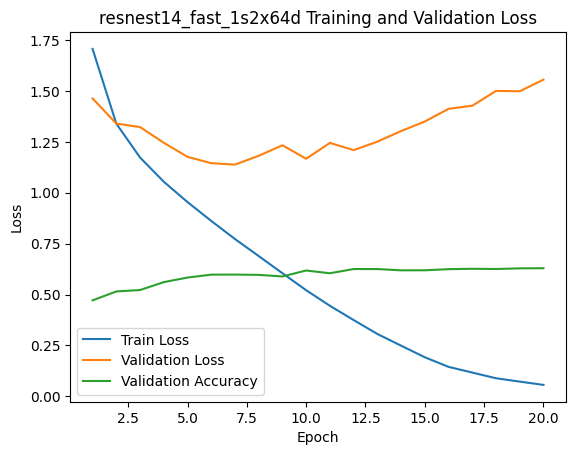

Average Latency per Sample (with warm-up): 0.13 ms
Throughput (with warm-up): 7646.11 samples/second
[('resnet14_1s1x64d', 0.0001311593770980835, np.float64(0.5868)), ('resnest14_fast_0s1x64d', 0.00017164301872253418, np.float64(0.6296)), ('resnest14_fast_1s1x64d', 0.00012824745178222657, np.float64(0.6121)), ('resnest14_fast_1s1x40d', 0.00014352922439575194, np.float64(0.6122)), ('resnest14_fast_1s2x64d', 0.0001307854413986206, np.float64(0.6295))]


In [3]:
model_dict = {}
result_list = []
model_dict['resnet14_1s1x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2)
model_dict['resnest14_fast_0s1x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=0, groups=1, bottleneck_width=64,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=True)
model_dict['resnest14_fast_1s1x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=1, groups=1, bottleneck_width=64,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=True)
model_dict['resnest14_fast_1s1x40d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=1, groups=1, bottleneck_width=40,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=True)
model_dict['resnest14_fast_1s2x64d'] = ResNet(Bottleneck, [1, 1, 1, 1],num_classes=10,final_drop=0.2,radix=1, groups=2, bottleneck_width=64,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=True)
for name,model in model_dict.items():
    avg_latency,max_acc = fit_one(name,model,20,train_dataloader,val_dataloader)
    result_list.append((name,avg_latency,max_acc))
print(result_list)